# Preliminary Analysis 

In [2]:
# In this notebook, we will load the data and perform preliminary analysis

In [3]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/10/02 17:39:52 WARN Utils: Your hostname, James-N580VD-DM229T resolves to a loopback address: 127.0.1.1; using 172.22.103.21 instead (on interface eth0)
22/10/02 17:39:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/02 17:39:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Read the files 
transactions_sample = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
consumer_details = spark.read.parquet('../data/tables/consumer_user_details.parquet')
merchants_tbl = spark.read.parquet('../data/tables/tbl_merchants.parquet')
customer_tbl = spark.read.option("delimiter", "|").option("header",True).csv('../data/tables/tbl_consumer.csv')

# Pre Process the tags column in tbl_merchants

In [5]:
merchants = merchants_tbl.toPandas()

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
import string
import re

# This is used to for NLP of the description
def text_process(text):
    stemmer = WordNetLemmatizer()
    # Remove all punctuation and numbers 
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    # Remove all stopwords
    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    # lemmatize and output
    return ' '.join([stemmer.lemmatize(word) for word in nopunc])

In [7]:
# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description and pre process
    descr = str(string_cut[0].strip('(('))
    #descr = re.sub(r'[-|,|_|:]', ' ', descr)
    #descr = re.sub(r' +', ' ', descr)
    #descr = descr.split()
    #descr = ' '.join([word for word in descr if word not in stop_words])
    new_string.append(text_process(descr))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [8]:
import pandas as pd
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))
merchant_tbl = pd.concat([merchants, merchant_tbl], axis=1)
# drop the tags column 
merchant_tbl.drop(columns='tags', inplace=True)

In [9]:
all_words = list(set(' '.join(set([' '.join(merchant_tbl['Description'])])).split()))

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfconvert = TfidfVectorizer().fit(all_words)

In [11]:
desc_transformed=tfidfconvert.transform(merchant_tbl['Description'])

In [12]:
# Need to work out how many unique labels there are
max_cluster = 5

In [13]:
from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=max_cluster, init='k-means++', n_init=100)
modelkmeans.fit(desc_transformed)

KMeans(n_clusters=5, n_init=100)

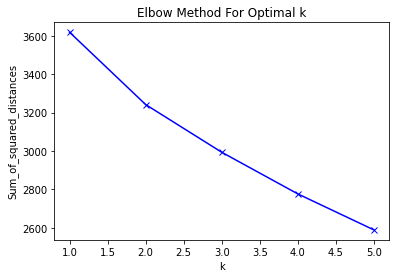

In [14]:
#checking for optimal number of clusters

from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,max_cluster + 1)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(desc_transformed)
    Sum_of_squared_distances.append(km.inertia_)


import matplotlib.pyplot as plt

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [15]:
km.fit_predict

<bound method _BaseKMeans.fit_predict of KMeans(n_clusters=5)>

In [16]:
len(km.labels_)

4026

In [21]:
merchant_tbl['labels'] = km.labels_

In [22]:
v = merchant_tbl.groupby('Description').agg(total = pd.NamedAgg('labels', lambda x: min(x)))
print(v)
v.sort_values(by='total', axis=0, inplace=True)

                                                    total
Description                                              
antique shop sale repair restoration service            4
art dealer gallery                                      3
artist supply craft shop                                0
bicycle shop sale service                               4
book periodical newspaper                               2
cable satellite pay television radio service            4
computer computer peripheral equipment software         3
computer programming data processing integrated...      4
digital good book movie music                           2
equipment tool furniture appliance rent al leasing      3
florist supply nursery stock flower                     1
furniture home furnishing equipment shop manufa...      3
gift card novelty souvenir shop                         0
health beauty spa                                       3
hobby toy game shop                                     0
jewelry watch 

# Grouping descriptions
After some through, and investigations of metrics for each description type, it has been decided to split companies into the following catergories: 
- Consumer (8)
[tent awning shop, shoe shop, optician optical good eyeglass, hobby toy game shop, gift card novelty souvenir shop, digital good book movie music, computer computer peripheral equipment software, antique shop sale repair restoration service*]
- Homeware & garden (3)
[equipment tool furniture appliance rent al leasing, florist supply nursery stock flower, lawn garden supply outlet including nursery, 
]
- Luxuries (7)
[watch clock jewelry repair shop, music shop musical instrument piano sheet music, jewelry watch clock silverware shop, health beauty spa*, cable satellite pay television radio service, bicycle shop sale service, art dealer gallery]
- Industry (7)
[telecom, stationery office supply printing writing paper, motor vehicle supply new part, furniture home furnishing equipment shop manufa..., 
computer programming data processing integrated..., book periodical newspaper, artist supply craft shop*]

In [ ]:
# 
v.drop()